### import library

keras와 tensorflow, numpy, matplotlib등의 library를 import해옵니다.   
사실 keras는 tensorflow의 API역할을 합니다.   
이전에 tensorflow가 버전이 낮았을 때는 tensorflow로만 다뤘었는데, 지금은 keras를 다루면 API역할을 하기 때문에 tensorflow를 더욱 쉽게 다룰 수 있게 된것입니다.  
그 외에 numpy는 array를 사용하기 위해, matplotlib은 이미지 plot을 할때 도움을 주는 library입니다.  
- keras
- tensorflow
- numpy 
- matplotlib

In [ ]:
import tensorflow as tf
import keras
print(tf.__version__)
print(keras.__version__)

### 함수 import해오기

utils는 one-hot coding을 하기 위해서, layers는 층을 쌓기 위해서, datasets은 keras에서 지원하는 데이터를 쓸 수 있게 하는함수  
EarlyStopping은 학습을 무한정하지 않고, 원하는 정확도와 loss값이 나오면 적절한 시기에서 종료하기 위해서 사용하는 함수  
나머지, Dense, Dropout, Flatten, Conv2D, MaxPooling2D와 같은 것들은 layer를 쌓기 위해 중간과정 layer

In [12]:
import tensorflow as tf
from tensorflow.keras import utils
from tensorflow.keras import layers
from tensorflow.keras import datasets, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

import numpy as np
import matplotlib.pyplot as plt

## load dataset from cifar10
datasets의 cifar10이라는 데이터 셋으로 총 60000개의 컬러이미지로 (32,32)데이터들로 구성된 데이터 셋이다.  
데이터의 클래스는 총 10개이고 랜덤하게 데이터가 저장되어있다.  

In [43]:
cifar_mnist = datasets.cifar10

(train_images,train_labels), (test_images, test_labels) = cifar_mnist.load_data()
#데이터를 가져와서, 데이터 수정을 하지 않기 위해서 튜플로 읽어온다. 
#train데이터와 test데이터를 각각 읽어와서 x,y혹은 이미지와 레이블로 저장을 해준다.

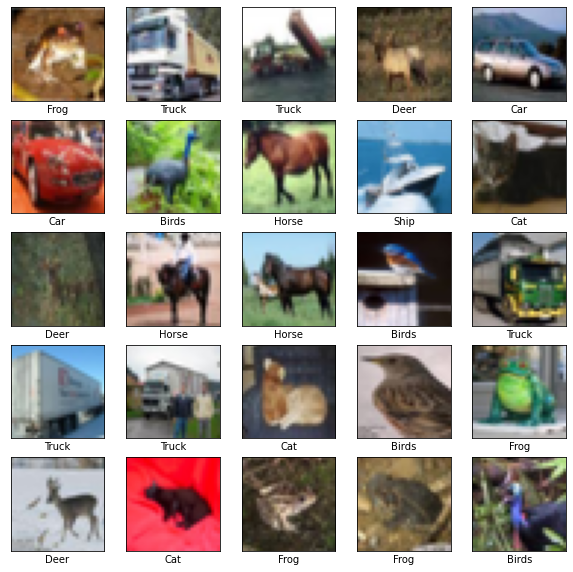

In [37]:
class_names = ['Airplane','Car','Birds','Cat','Deer','Dog','Frog','Horse','Ship','Truck']
#class_name은 우리가 6만개의 데이터로 레이블을 해줄 값들을 저장한 것이다. 

plt.figure(figsize=(10,10))

#25개의 이미지만 로드해보겠다. 
#cmap함수는 기존에 입력된 색상 정보를 이용해서 색을 입힌다. 
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i],cmap=plt.cm.binary)
    #cmap : 색 입혀주는 함수
    plt.xlabel(class_names[train_labels[i][0]])
    
plt.show()

## load data

batch size나 epoch과 같이 초기조건을 설정해준다.  
batch 사이즈는 한번 학습시킬때 데이터 개수이다. 예를 들어, 전체 데이터에서 64개씩 뽑아서 학습시키고 가중치를 update한다.  
epoch은 전체 데이터를 한바뀌 다 돌면 1epoch이다. 학습횟수라고 할 수 있다. 


In [45]:
batch_size = 64 #전체 데이터에서 한번 학습시킬때 개수, weight update를 64개 할때마다 
num_classes = len(class_names) #length함수를 써서 output label의 개수를 얻어낸다.
epoch = 35 #전체 데이터를 한바뀌 돌면 1 epoch: 학습횟수 

train_dataset = train_images.astype('float32') 

#우리가 사용하려는 데이터의 shape을 보고, 최솟값은 무엇인지, max값은 무엇인지 보도록 하자 
print(train_images.shape,np.max(train_images),np.min(train_images))
#값을 normalization하여 사용하기 위해서 255로나누어준다. 
train_dataset = train_dataset /255 #normalization


#test data도 마찬가지로 
test_dataset = test_images.astype('float32')
test_dataset = test_dataset/255


#train과 test의 label을 one-hot coding으로 변환
train_y = utils.to_categorical(train_labels, num_classes)
test_y = utils.to_categorical(test_labels, num_classes) 

(50000, 32, 32, 3) 255 0


In [46]:
print(test_y)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]


In [52]:
test_dataset.shape

(10000, 32, 32, 3)

## data set split 

train_test_split함수를 사용해서 train데이터에서 validation data를 추출할 것이다.  

In [59]:
from sklearn.model_selection import train_test_split
X_train, X_valid, Y_train, Y_valid = train_test_split(train_dataset, train_y, 
                                                    test_size=0.2, random_state=1) 
# random_state를 1로 해주면, 누가 사용하던 똑같이 random하게 나온다.

## CNN layer 생성

keras.Sequential함수를 사용해서 각 레이어 층을 연속적으로 작성하여 레이어를 쌓아준다.  
우리는 Conv2D+MaxPooling+Dropout을 2번 실행하고 flatten함수로 1차원 데이터로변환한뒤, Dense함수를 이용해서 fully connected layer를 만들어 neural network를 할 것이다. 


In [47]:
model = Sequential([
    Conv2D(32, kernel_size = (3,3), padding ='same', input_shape = train_dataset.shape[1:],
          activation = tf.nn.relu),
    #filter를 32장 => 다 다른 feature를 보기위함, 각 뉴런을 만드는것
    MaxPooling2D(pool_size = (2,2)),
    Dropout(0.25), #0.25비율을 빼고 학습 prediction할때는 전부 빼기
    
    Conv2D(64,kernel_size = (3,3), padding='same', activation=tf.nn.relu),
    MaxPooling2D(pool_size = (2,2)),
    Dropout(0.25), #dropout안해줘도 성능차이가 크지 않다
    
    Flatten(),
    Dense(64, activation = tf.nn.relu),
    Dropout(0.25),
    Dense(num_classes, activation=tf.nn.softmax)
])

model.summary() #summary치면 나옴 잘 정리되서 output shape을 보기 좋음 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0

## 학습준비
model.compile해서 학습준비를 합니다. loss함수로 무엇을 줄건지, optimizer는 무엇을 줄지, metrics는 뭘 볼건지 등등



In [49]:
model.compile(
    loss ='categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy'])

In [63]:
early_stopping = EarlyStopping(monitor='val_loss',patience=10) #지정한 epoch까지 계속 학습하기 때문에, 오버피팅을 막기위해서 validation의 loss가 최대일때 정지하게 함, patience=10인것은 10번 참으라는 뜻

history = model.fit(
    X_train, Y_train,
    epochs = epoch,
    validation_data = (X_valid, Y_valid),
    shuffle = True,
    callbacks = [early_stopping])

#1250인 이유 = train data/ batch size
#loss가 줄어들면 잘 학습되고 있음

Epoch 1/35
1250/1250 [==============================] - 8s 7ms/step - loss: 1.2958 - accuracy: 0.5304 - val_loss: 1.1427 - val_accuracy: 0.5945
Epoch 2/35
1250/1250 [==============================] - 8s 6ms/step - loss: 1.2119 - accuracy: 0.5656 - val_loss: 1.0957 - val_accuracy: 0.6194
Epoch 3/35
1250/1250 [==============================] - 8s 7ms/step - loss: 1.1700 - accuracy: 0.5813 - val_loss: 1.0814 - val_accuracy: 0.6286
Epoch 4/35
1250/1250 [==============================] - 8s 6ms/step - loss: 1.1177 - accuracy: 0.5989 - val_loss: 0.9787 - val_accuracy: 0.6556
Epoch 5/35
1250/1250 [==============================] - 8s 7ms/step - loss: 1.0795 - accuracy: 0.6130 - val_loss: 0.9806 - val_accuracy: 0.6557
Epoch 6/35
1250/1250 [==============================] - 8s 6ms/step - loss: 1.0534 - accuracy: 0.6233 - val_loss: 0.9514 - val_accuracy: 0.6709
Epoch 7/35
1250/1250 [==============================] - 8s 6ms/step - loss: 1.0287 - accuracy: 0.6334 - val_loss: 0.9316 - val_accuracy:

In [66]:
loss, acc = model.evaluate(X_train, Y_train)

loss, acc = model.evaluate(test_dataset, test_y)

print(f'\nLoss: {loss}, Acc: {acc}') #test set 의 결과

313/313 [==============================] - 1s 3ms/step - loss: 0.8193 - accuracy: 0.7257

Loss: 0.8192588686943054, Acc: 0.7257000207901001


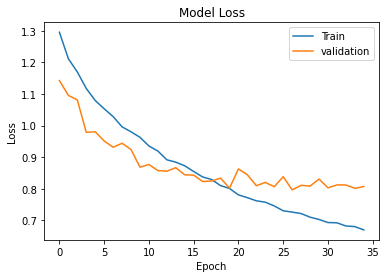

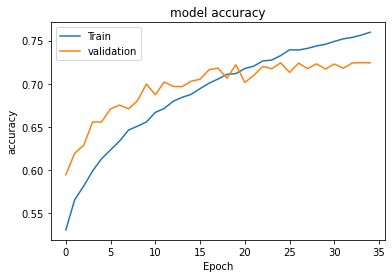

In [77]:
def plt_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train','validation'], loc=0)
    
def plt_acc(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train','validation'],loc=0)
    
plt_loss(history)
plt.show()

plt_acc(history)
plt.show()


#train은 계속 연산하면 0으로 수렴하는데, validation은 overfitting되서 다시 올라간다.